In [797]:
import warnings 
warnings.filterwarnings("ignore")

In [798]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
from sklearn.metrics import f1_score, accuracy_score
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler




df = pd.read_csv("German Credit Cards UCI.csv")

features = df.drop(['Customer ID', 'Loan Status'], axis=1)
target_variable = df['Loan Status']
RANDOM_STATE = 42

features.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1014 entries, 0 to 1013
Data columns (total 20 columns):
 #   Column                                               Non-Null Count  Dtype 
---  ------                                               --------------  ----- 
 0   Checking Account Status                              1014 non-null   object
 1   Loan Duration (Months)                               1014 non-null   int64 
 2   Credit History                                       1014 non-null   object
 3   Purpose                                              1014 non-null   object
 4   Loan Amount                                          1014 non-null   int64 
 5   Savings Account Balance                              1014 non-null   object
 6   Present Employment Time (Years)                      1014 non-null   object
 7   Installment Rate in Percentage of Disposable Income  1014 non-null   int64 
 8   Personal Status and Gender                           1014 non-null   object
 9

In [799]:
target_counts = df["Loan Status"].value_counts()
print(target_counts)


Loan Status
fully paid     711
charged off    303
Name: count, dtype: int64


In [800]:
target_variable = np.where(df['Loan Status'] == 'fully paid', 1, 0)
print(target_variable)

[1 0 1 ... 1 1 0]


In [801]:
unique_values, counts = np.unique(target_variable, return_counts=True)

target_counts = pd.Series(counts, index=unique_values)
print(target_counts)

0    303
1    711
dtype: int64


In [802]:
data_types = df.dtypes
print(data_types)

Customer ID                                             int64
Checking Account Status                                object
Loan Duration (Months)                                  int64
Credit History                                         object
Purpose                                                object
Loan Amount                                             int64
Savings Account Balance                                object
Present Employment Time (Years)                        object
Installment Rate in Percentage of Disposable Income     int64
Personal Status and Gender                             object
Other Debtors / Guarantors                             object
Present Residence Time (Years)                          int64
Property                                               object
Age (Years)                                             int64
Other Credits                                          object
Home Ownership                                         object
Number o

In [803]:
numeric_columns = features.select_dtypes(include='number').columns
numeric_columns

Index(['Loan Duration (Months)', 'Loan Amount',
       'Installment Rate in Percentage of Disposable Income',
       'Present Residence Time (Years)', 'Age (Years)',
       'Number of Existing Credits at This Bank', 'Number of Dependents'],
      dtype='object')

In [804]:
#scaler = MinMaxScaler() 
scaler = StandardScaler() 
features[numeric_columns] = scaler.fit_transform(features[numeric_columns])


In [805]:
categorical_columns = features.select_dtypes(include='object').columns
categorical_columns

Index(['Checking Account Status', 'Credit History', 'Purpose',
       'Savings Account Balance', 'Present Employment Time (Years)',
       'Personal Status and Gender', 'Other Debtors / Guarantors', 'Property',
       'Other Credits', 'Home Ownership', 'Job Category', 'Telephone',
       'Foreign Worker Status'],
      dtype='object')

In [806]:
encoder = ce.TargetEncoder()

features[categorical_columns] = encoder.fit_transform(features[categorical_columns], target_variable)
# encoder = LabelEncoder()

# for column in categorical_columns:
#     features[column] = encoder.fit_transform(features[column])

In [807]:
features.shape
features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1014 entries, 0 to 1013
Data columns (total 20 columns):
 #   Column                                               Non-Null Count  Dtype  
---  ------                                               --------------  -----  
 0   Checking Account Status                              1014 non-null   float64
 1   Loan Duration (Months)                               1014 non-null   float64
 2   Credit History                                       1014 non-null   float64
 3   Purpose                                              1014 non-null   float64
 4   Loan Amount                                          1014 non-null   float64
 5   Savings Account Balance                              1014 non-null   float64
 6   Present Employment Time (Years)                      1014 non-null   float64
 7   Installment Rate in Percentage of Disposable Income  1014 non-null   float64
 8   Personal Status and Gender                           1014 non-null  

In [808]:
features_train, features_test, target_train, target_test = train_test_split(features, target_variable, test_size=0.2, stratify=target_variable, random_state=RANDOM_STATE) 

target_train = np.array(target_train).reshape(-1, 1)
target_test = np.array(target_test).reshape(-1, 1)
target_test.shape

(203, 1)

In [809]:
#Данный класс плохо работает на исходных данных, модель обученная на этом классе предсказывает только 1, как бы я не старался это исправить БЕЗ изменения этого класса, поэтому я решил использовать svm и svc из sklearn. Модель обученная на данной библиотеки показала адекватные значения.
class SVMClassification(object):
    def __init__(self, learning_rate=0.01, lam=0.1, max_iter=200):
        self.max_iter = max_iter
        self.learning_rate = learning_rate
        self.lam = lam
        self.w = None
        self.history_w = []
        self.errors = None
        self.loss = None

    def predict(self, X):
        x_ext = self.add_intercept(X)
        return np.sign(np.dot(x_ext, self.w))

    def hinge_loss(self, x, y):
        return max(0, 1 - y * (np.dot(x, self.w)))

    def soft_margin_loss(self, x, y):
        return self.hinge_loss(x, y) + self.lam * (np.dot(self.w, self.w))

    def add_intercept(self, X):
        return np.column_stack((np.ones(len(X)), X))

    def fit(self, X, Y, verbose=False):
        X = self.add_intercept(X)
        self.w = np.random.normal(loc=0, scale=0.05, size=X.shape[1])
        self.history_w.append(self.w)
        errors = []
        loss_epoch = []

        for epoch in range(self.max_iter):
            err = 0
            loss = 0
            for i, x in enumerate(X):
                margin = Y[i] * (np.dot(self.w, X[i]))
                if margin >= 1:
                    self.w -= self.learning_rate * self.lam * self.w / self.max_iter
                    loss += self.soft_margin_loss(X[i], Y[i])
                else:
                    self.w += self.learning_rate * (Y[i] * X[i] - self.lam * self.w / self.max_iter)
                    err += 1
                    loss += self.soft_margin_loss(X[i], Y[i])
                self.history_w.append(self.w)
            if verbose:
                print('epoch {}. Errors={}. Mean Hinge_loss={}'.format(epoch, err, loss))
            errors.append(err)
            loss_epoch.append(loss)
        self.history_w = np.array(self.history_w)
        self.errors = np.array(errors)
        self.loss = np.array(loss_epoch)

In [810]:
# Подбор оптимального значения С
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}


svm_model = SVC(kernel='linear')


grid_search = GridSearchCV(svm_model, param_grid, cv=5, scoring='accuracy')


grid_search.fit(features_train, target_train)


best_C = grid_search.best_params_['C']
print(f"Лучшее значение C: {best_C}")


Лучшее значение C: 10


In [825]:
# Результаты с балансировкой хуже, чем без нее-_-
over_sampler = RandomOverSampler(sampling_strategy='minority', random_state=RANDOM_STATE)
features_resampled, target_resampled = over_sampler.fit_resample(features_train, target_train)

# svm_classifier = SVMClassification(learning_rate=0.001, lam=0.1, max_iter=200)
svm_classifier = SVC(kernel='linear', C=10, max_iter=300) #class_weight='balanced'
svm_classifier.fit(features_train, target_train)


predictions = svm_classifier.predict(features_test)


accuracy = accuracy_score(target_test, predictions)
print('Accuracy модели:', accuracy)
f1_score_value = f1_score(target_test, predictions)
print('F1 score модели:', f1_score_value)

Accuracy модели: 0.7536945812807881
F1 score модели: 0.8333333333333333


In [812]:
print(predictions)
print(len(predictions))

[1 1 1 1 1 0 1 1 1 1 1 1 1 0 0 0 1 1 1 1 0 1 1 1 1 0 0 0 1 1 1 0 1 1 1 1 1
 1 1 1 1 1 1 1 0 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 0 1 1 1
 1 1 0 0 1 0 0 0 1 0 1 0 1 1 1 1 1 0 1 1 1 0 1 1 1 1 1 1 1 0 1 1 1 1 0 1 0
 1 1 1 1 0 1 1 1 0 1 1 1 1 0 1 0 0 1 1 1 1 0 1 0 1 1 0 0 1 1 1 1 1 1 1 1 1
 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 1 1 1 1 1 1 0 1 1 1 1
 1 1 1 0 1 0 0 1 0 1 1 1 0 1 0 1 1 1]
203


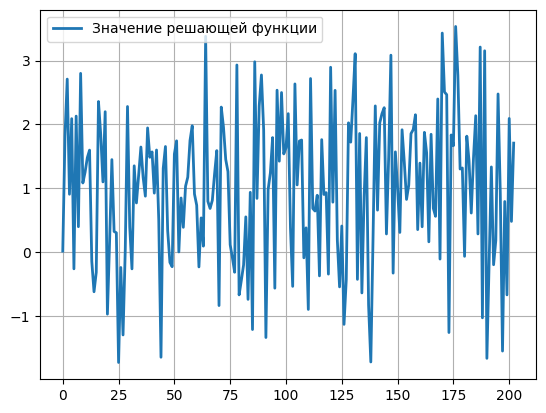

In [816]:

decision_function_values = svm_classifier.decision_function(features_test)
plt.plot(decision_function_values, linewidth=2, label='Значение решающей функции')
plt.grid()
plt.legend()
plt.show()


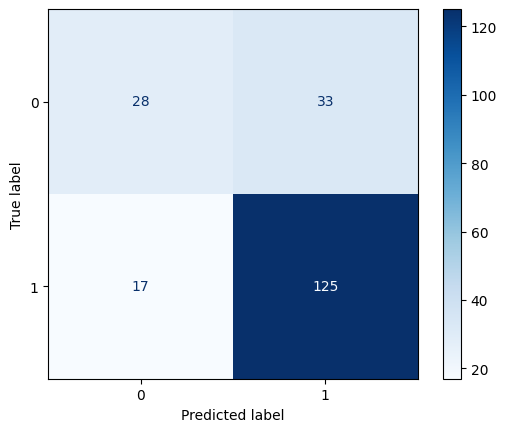

In [814]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(target_test,svm_classifier.predict(features_test), labels=[0, 1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
_ = disp.plot(cmap=plt.cm.Blues)
